sbpy.data.Obs Example Notebook
=================================

[sbpy.data.Obs](https://sbpy.readthedocs.io/en/latest/api/sbpy.data.Obs.html) provides functionality to deal with observational data. The following examples provide a brief introduction on how to use this sub-module.

Curating dense observations and plotting a lightcurve
------------------------

Dense observations are relatively short observational sequences in which one target is continuously monitored, e.g., to measure its brightness. This examples show how you can curate dense observations in an `Obs` object. The data will then be used to plot the target's lightcurve.  

First, we need some data, namely the epochs of the observations and the measured magnitudes. Typically, this information would be extracted from a log file or some FITS image headers. In this case, we simply generate some synthetic epochs and magnitudes, the latter of which are modulated following a sine curve and some Gaussien noise has been added.

In [1]:
import numpy as np
from astropy.time import Time
import astropy.units as u

# set random seed to make results reproduceable
np.random.seed(42)

epochs = Time(2451234 + np.linspace(0, 0.3, 100), format='jd')
mag = (12.0 + 0.5*np.sin((epochs.jd-2451234)/0.05*np.pi)+np.random.normal(scale=0.2, size=100))*u.mag

The `Obs` object can be built from a simple dictionary:

In [2]:
from sbpy.data import Obs

obs = Obs.from_dict({'epoch': epochs, 'mag': mag})

Text(0, 0.5, 'Magnitude')

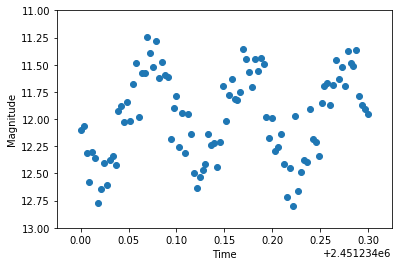

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(obs['epoch'].jd, obs['mag'])
plt.ylim([13, 11])
plt.xlabel('Time')
plt.ylabel('Magnitude')

This is a very simplistic example. In order to show you the full potential of `Obs`, consider the following example.

Curating sparse observations and plotting a phase curve
------------------------------------

Sparse observations are observations that are typically taken over a long period of time with varying spacing between individual data points in time. In this example, we simulate observations of asteroid `3552 Don Quixote` obtained from Maunakea on discrete nights and plot the phase curve of this asteroid.

Assume that observations were taken on these nights:

In [4]:
from sbpy.data import Obs
from astropy.time import Time

epochs = Time(['2017-10-03', '2017-10-21', '2017-11-15', '2017-12-23', '2018-01-05', '2018-04-13'])

obs = Obs.from_dict({'targetname': ['3552']*6, 'epoch': epochs}, meta={'observatory':'568'})

We initialize `obs` with `epochs` and a 'targetname' column. The latter is required for the use of `supplement` later. We also add the observatory code in the meta data; this is not required, but comes in handy if you are dealing with a number of different `obs` objects.

Magnitudes measured on these nights are as follows:

In [5]:
mag = [[18.2, 18.4, 17.9, 18.3, 18.7],
       [17.9, 18.1, 18.3],
       [17.5, 18.2, 17.9, 17.8],
       [16.9, 17.9, 17.4],
       [17.5, 17.6],
       [15.5, 15.9, 16.3, 15.7, 15.8]]

Please note that each sub-list in `mag` refers to magnitudes measured on the corresponding nights defined in `epochs`. Also, no units are applied here for reasons explained below.

This situation - to have observational data provided for discrete epochs - is rather common and can be cumbersome to handle if the goal is to create a `Obs` object in which each row contains the corresponding epoch and magnitude of one of the observations. It requires some skill and time to re-format the data in a form that can be used in the typical DataClass class methods.

The [apply](https://sbpy.readthedocs.io/en/latest/api/sbpy.data.DataClass.html#sbpy.data.DataClass.apply) function has been designed to deal with this problem. This function re-formats an existing DataClass object and applies a new column to this object. The new data must be present as a sequence with the same length as there are rows in the DataClass object. If an element in the sequence is a sequence itself, the corresponding DataClass row is duplicated for each element in the sub-sequence. The result is a nicely formatted DataClass object.

Let's have a look at how it works in this case. We want to apply the `mag` sequence on the `obs` object:

In [6]:
obs

<QTable length=6>
targetname          epoch         
   str4             object        
---------- -----------------------
      3552 2017-10-03 00:00:00.000
      3552 2017-10-21 00:00:00.000
      3552 2017-11-15 00:00:00.000
      3552 2017-12-23 00:00:00.000
      3552 2018-01-05 00:00:00.000
      3552 2018-04-13 00:00:00.000

In [7]:
obs.apply(mag, name='mag', unit='mag')
obs

<QTable length=22>
targetname          epoch            mag  
                                     mag  
   str4             object         float64
---------- ----------------------- -------
      3552 2017-10-03 00:00:00.000    18.2
      3552 2017-10-03 00:00:00.000    18.4
      3552 2017-10-03 00:00:00.000    17.9
      3552 2017-10-03 00:00:00.000    18.3
      3552 2017-10-03 00:00:00.000    18.7
      3552 2017-10-21 00:00:00.000    17.9
      3552 2017-10-21 00:00:00.000    18.1
      3552 2017-10-21 00:00:00.000    18.3
      3552 2017-11-15 00:00:00.000    17.5
       ...                     ...     ...
      3552 2017-12-23 00:00:00.000    16.9
      3552 2017-12-23 00:00:00.000    17.9
      3552 2017-12-23 00:00:00.000    17.4
      3552 2018-01-05 00:00:00.000    17.5
      3552 2018-01-05 00:00:00.000    17.6
      3552 2018-04-13 00:00:00.000    15.5
      3552 2018-04-13 00:00:00.000    15.9
      3552 2018-04-13 00:00:00.000    16.3
      3552 2018-04-13 00:00:00.000 

Note how `apply` extended `obs` and duplicates the epochs that it was holding for each of the observations. Also note that `apply` requires a `name` and an optional `unit` for the data provided; the data itself (`mag`) are dimensionless in this case.

Now we can plot the data.

Text(0, 0.5, 'Magnitude')

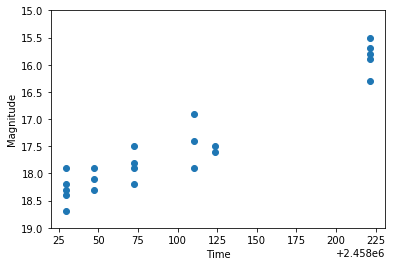

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(obs['epoch'].jd, obs['mag'])
plt.ylim([19, 15])
plt.xlabel('Time')
plt.ylabel('Magnitude')

This plot clearly shows the brightening of asteroid Don Quixote as a function of time.

However, in order to get a real phase curve, we have to plot the reduced magnitude, which is corrected for distance effects, against the target's solar phase angle. Hence, we need the heliocentric distance, the distance from the observer, and the target's solar phase angle. 

These properties can be easily obtained using the [supplement](https://sbpy.readthedocs.io/en/latest/api/sbpy.data.Obs.html#sbpy.data.Obs.supplement) function that is part of the Obs class. This function supplements the data provided in an Obs object with ephemerides queried from one of the services available in [sbpy.data.Ephem](https://sbpy.readthedocs.io/en/latest/api/sbpy.data.Ephem.html#sbpy.data.Ephem). We choose the JPL Horizons system here:

In [9]:
obs_sup = obs.supplement(service='jplhorizons', id_field='targetname', 
                         epoch_field='epoch', location=obs.meta['observatory'])

The `id_field` and `epoch_field` keyword arguments define the field names for the target identifier and epoch, respectively.

With the additional information, we can remove the distance module and plot the magnitudes as a function of solar phase angle.

Text(0, 0.5, 'Reduced Magnitude')

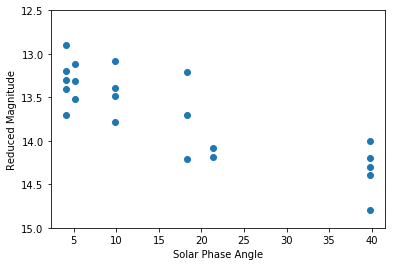

In [10]:
plt.scatter(obs_sup['alpha'], obs_sup['mag']-5*np.log10(obs_sup['r'].to('au').value*obs_sup['delta'].to('au').value)*u.mag)
plt.ylim([15, 12.5])
plt.xlabel('Solar Phase Angle')
plt.ylabel('Reduced Magnitude')

This is our phase curve plot. Please have a look at the `sbpy.photometry` notebooks to learn how to perform phase curve fitting.

Retrieving observations from the Minor Planet Center
------------------

All observations of small bodies are collected at the [Minor Planet Center](https://minorplanetcenter.net/) and can be retrieved from their database. The following example shows how to retrieve and use such observations for asteroid 3552.

In [11]:
from sbpy.data import Obs

obs = Obs.from_mpc('3552')
obs

<QTable masked=True length=1253>
number  desig  discovery note1 ...         DEC           mag   band observatory
                               ...         deg           mag                   
int64    str7     str1    str1 ...       float64       float64 str1     str3   
------ ------- --------- ----- ... ------------------- ------- ---- -----------
  3552 1983 SA        --     6 ...  -5.219888888888889     0.0   --         688
  3552 1983 SA        --     6 ...  -5.170138888888889     0.0   --         688
  3552 1983 SA        --     ! ... -2.5810555555555554     0.0   --         675
  3552 1983 SA        --     ! ...             -2.5685     0.0   --         675
  3552 1983 SA         *    -- ...  11.328222222222221    14.0   --         026
  3552 1983 SA        --    -- ...  12.618472222222223     0.0   --         026
  3552 1983 SA        --    -- ...  14.390888888888888     0.0   --         026
  3552 1983 SA        --    -- ...  14.403638888888889     0.0   --         026
  3552 

That's more than 1000 observations. In order to limit the data set, we only select observations obtained by either of the ATLAS telescopes (observatory codes `'T05'` and `'T08'`) using the `o` filter:

In [12]:
atlas = Obs.from_table(obs[(obs['band'] == 'o') & ((obs['observatory'] == 'T05') | (obs['observatory'] == 'T08'))])

Now we plot this rather homogeneous data set:

Text(0, 0.5, 'Magnitude')

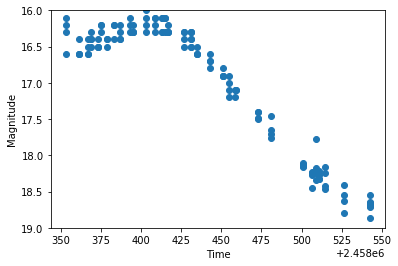

In [13]:
plt.scatter(atlas['epoch'].jd, atlas['mag'])
plt.ylim([19, 16])
plt.xlabel('Time')
plt.ylabel('Magnitude')